Questão 01: A partir de determinada imagem, será produzido, em nível de cinza:

• Escolha cenários com bordas presentes;

• Degrade a imagem com ruído “sal e pimenta”;

• Aplique as diversas máscaras de filtragem com preservação de bordas:

    o Kuwahara et al. (1976);

    o Tomita e Tsuji (1977);

    o Nagao e Matsuyama (1979);

    o Somboonkaew et al. (1999);

    o Adelmann (1999).
    
• E compare com algum método tradicional.

In [8]:
import random
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def add_ruido(img):

    linha, coluna = img.shape

    numero_pixels = random.randint(300, 100000)
    for i in range(numero_pixels):

        coordenada_y = random.randint(0, linha - 1)
        coordenada_x = random.randint(0, coluna - 1)

        img[coordenada_y][coordenada_x] = 255

    numero_pixels = random.randint(300, 100000)
    for i in range(numero_pixels):

        coordenada_y = random.randint(0, linha - 1)
        coordenada_x = random.randint(0, coluna - 1)

        img[coordenada_y][coordenada_x] = 0

    return img

Após a adição do ruido "Sal e Pimenta", agora podemos trabalhar com essa nova imagem, logo abaixo é apresentado e imagem original ao lado da imagem com ruido.

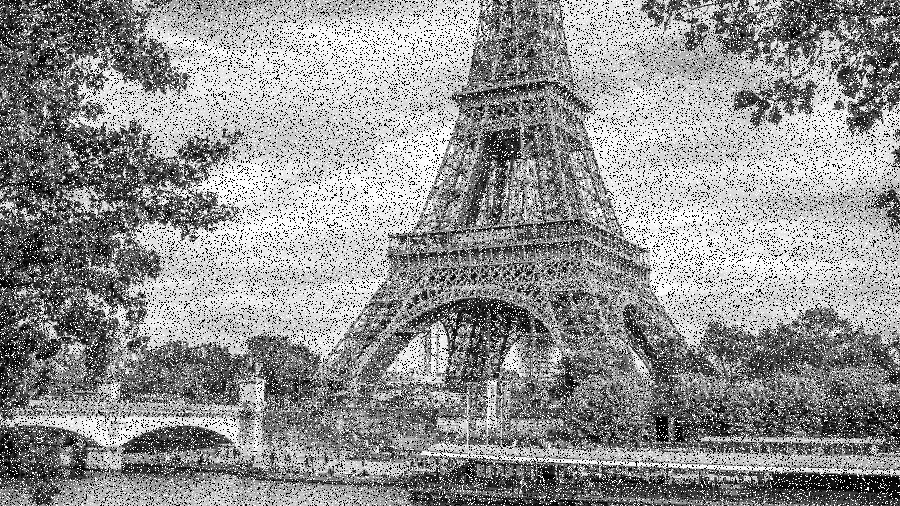

In [9]:
img = cv2.imread('eifel.jpg', cv2.IMREAD_GRAYSCALE)

cv2.imwrite('eifel_ruido.jpg', add_ruido(img))

im1 = Image.open('eifel.jpg')
im1

im2 = Image.open('eifel_ruido.jpg')
im2

# res1 = np.hstack((im1, im2))
# cv2.imwrite('eifel_ruido_lado_lado.jpg', res1)

# res2 = Image.open('eifel_ruido_lado_lado.jpg')
# res2

Agora podemos trabalhar com essa nova imagem, primeiro vamos aplicar a filtragem de Kuwahara.
O filtro de Kuwahara pode ser definido como um filtro não linear de suavização que não compromete a nitidez da imagem ou as posições das bordas, sendo reconhecido tradicionalmente por este segundo aspecto.

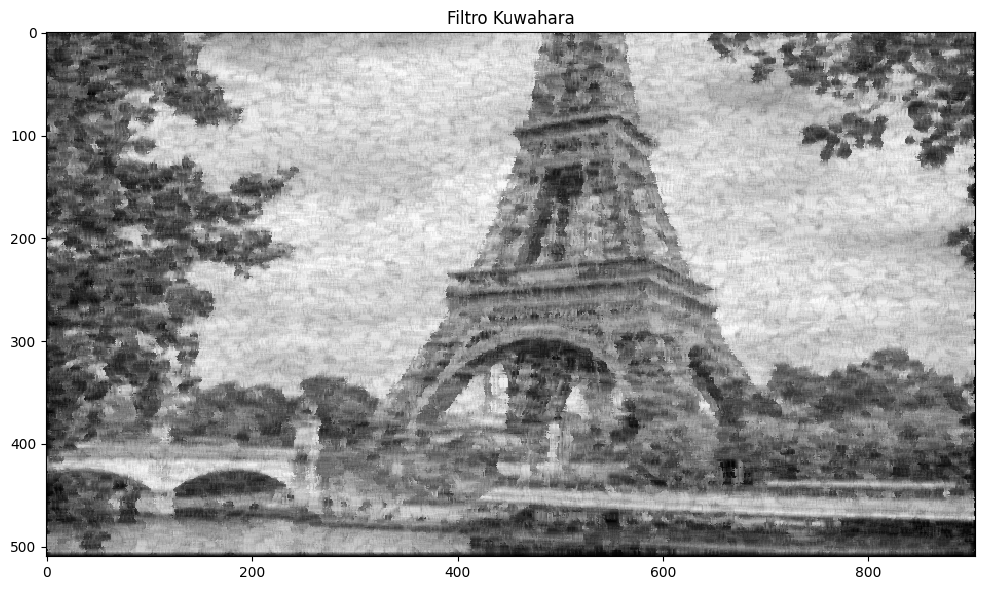

In [10]:
from scipy.signal import convolve2d
from skimage import io

def Kuwahara(img, janelaTamanho):
     # Adiciona bordas à imagem para processar as bordas corretamente
    img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_REFLECT)

    image = img.astype(np.float64)
    # Verificando se o tamanho da janela está correto

    if janelaTamanho % 4 != 1:
        raise Exception ("Tamanho de Janela Invalido")
    
    #Construindo Sub Janelas
    janela_1 = np.hstack((np.ones((1, (janelaTamanho-1)//2+1)), np.zeros((1, (janelaTamanho - 1)//2))))
    matriz_de_zeros = np.zeros((1, janelaTamanho))
    matriz_retangular = np.tile(janela_1, ((janelaTamanho - 1)//2+1,1))
    matriz_retangular = np.vstack((matriz_retangular, np.tile(matriz_de_zeros, ((janelaTamanho-1)//2, 1))))
    matriz_retangular = matriz_retangular/np.sum(matriz_retangular)
    # normaliza o kernel dividindo todos os seus elementos pela soma de 
    # todos os elementos,
    # o que garante que os pesos do kernel somam 1 (ou seja, a propriedade 
    # de filtro média)

    janelas = np.empty((4, janelaTamanho, janelaTamanho))
    janelas[0] = matriz_retangular  # janelas[0] representa a direção noroeste.
    janelas[1] = np.fliplr(matriz_retangular) # janelas[1] representa a direção nordeste.
    janelas[2] = np.fliplr(matriz_retangular)  # janelas[2] representa a direção sudoeste.
    janelas[3] = np.fliplr(janelas[2]) # janelas[3] representa a direção sudeste.
   
    quadradoImg = image**2

    #alocando arrays
    avgs = np.zeros([4, image.shape[0], image.shape[1]])
    alocar = avgs.copy()

    #calculando a media de variancia
    for k in range(4):
        avgs[k] = convolve2d(image, janelas[k], mode='same')

        #media dos quadrados das subjanelas
        alocar[k] = convolve2d(quadradoImg, janelas[k], mode='same')

        #variancia das subjanelas
        alocar[k] = alocar[k] - avgs[k]**2

    #Escolhendo o indice com menor variancia
    indices = np.argmin(alocar, 0)

    #Construindo o filtro da imagem para cada pixel
    filtrado = np.zeros(img.shape)
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            filtrado[linha, coluna] = avgs[indices[linha, coluna], linha, coluna]

   
    return filtrado.astype(np.uint8)


img_ruido = np.array(Image.open('eifel_ruido.jpg'))
imgNormalKuwahara = Kuwahara(img_ruido, 9)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro Kuwahara")
io.imshow(imgNormalKuwahara/255)
plt.show()


Podemos agora aplicar o filtro de Tomita e Tsuji, nesse caso ambos usam da mesma forma uma mascara assim como o de Kuwahara, entretando aqui será aplicado cinco mascaras, ao inves de apenas 4, sendo a 5ª colocando o pixel trabalhado no centro. Por serem bem semelhantes o resultado dos dois filtros numa mesma imagem mostram resultados que se diferem pouco um do outro.

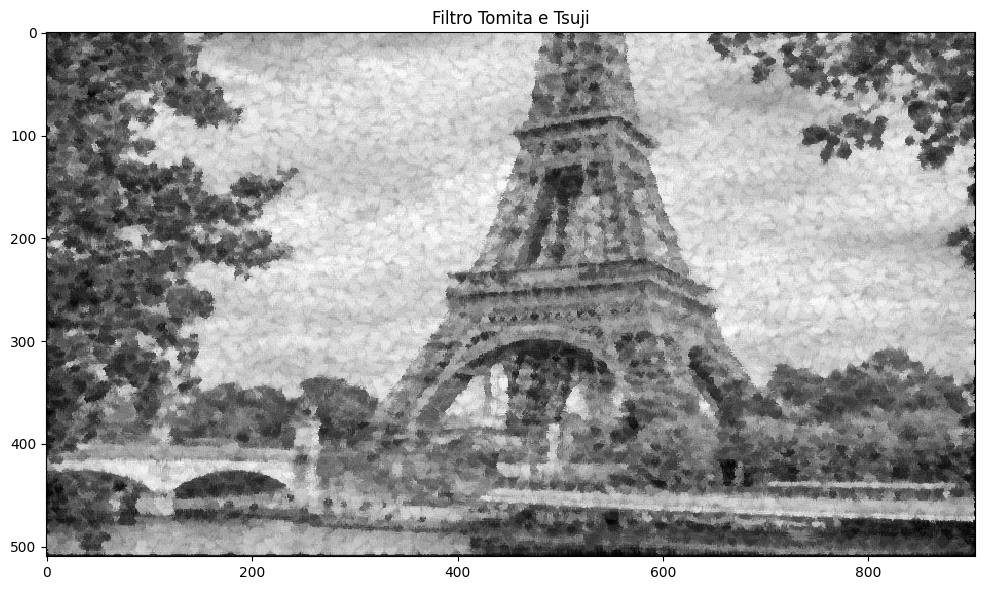

In [11]:
from scipy.signal import convolve2d
from skimage import io

def TomitaTsuji(img, janelaTamanho):
     # Adiciona bordas à imagem para processar as bordas corretamente
    img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_REFLECT)
    
    image = img.astype(np.float64)
    # Verificando se o tamanho da janela está correto

    if janelaTamanho % 4 != 1:
        raise Exception ("Tamanho de Janela Invalido")
    
    #Construindo Sub Janelas
    janela_1 = np.hstack((np.ones((1, (janelaTamanho-1)//2+1)), np.zeros((1, (janelaTamanho - 1)//2))))
    matriz_de_zeros = np.zeros((1, janelaTamanho))
    matriz_retangular = np.tile(janela_1, ((janelaTamanho - 1)//2+1,1))
    matriz_retangular = np.vstack((matriz_retangular, np.tile(matriz_de_zeros, ((janelaTamanho-1)//2, 1))))
    matriz_retangular = matriz_retangular/np.sum(matriz_retangular)
    # normaliza o kernel dividindo todos os seus elementos pela soma de 
    # todos os elementos,
    # o que garante que os pesos do kernel somam 1 (ou seja, a propriedade 
    # de filtro média)

    matriz_aux = matriz_retangular.copy()

    l = matriz_aux[0][0]
    p = matriz_aux[0][8]

    for i in range(len(matriz_aux)):
        for j in range(len(matriz_aux)):
            matriz_aux[i][j] = p
    
    for i in range(2, 7):
        for j in range(2, 7):
            matriz_aux[i][j] = l

    janelas = np.empty((5, janelaTamanho, janelaTamanho))
    janelas[0] = matriz_retangular  # janelas[0] representa a direção noroeste.
    janelas[1] = np.fliplr(matriz_retangular) # janelas[1] representa a direção nordeste.
    janelas[2] = np.fliplr(matriz_retangular)  # janelas[2] representa a direção sudoeste.
    janelas[3] = np.fliplr(janelas[2]) # janelas[3] representa a direção sudeste.
    janelas[4] = matriz_aux # janelas[4] representa a direção do meio.

    quadradoImg = image**2

    #alocando arrays
    avgs = np.zeros([5, image.shape[0], image.shape[1]])
    alocar = avgs.copy()

    #calculando a media de variancia
    for k in range(5):
        avgs[k] = convolve2d(image, janelas[k], mode='same')

        #media dos quadrados das subjanelas
        alocar[k] = convolve2d(quadradoImg, janelas[k], mode='same')

        #variancia das subjanelas
        alocar[k] = alocar[k] - avgs[k]**2

    #Escolhendo o indice com menor variancia
    indices = np.argmin(alocar, 0)

    #Construindo o filtro da imagem para cada pixel
    filtrado = np.zeros(img.shape)
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            filtrado[linha, coluna] = avgs[indices[linha, coluna], linha, coluna]

    return filtrado.astype(np.uint8)


img_ruido = np.array(Image.open('eifel_ruido.jpg'))
imgTomitaTsuji = TomitaTsuji(img_ruido, 9)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro Tomita e Tsuji")
io.imshow(imgTomitaTsuji/255)
plt.show()



Abaixo a aplicação do filtro de Nagao e Matsuyama, nesse caso a quantidade mascaras usada é de 9 ao todo, como consequencia é uma extensão do filtro de média, com a diferença de que as máscaras utilizadas no Nagao e Matsuyama são adaptadas para preservar as bordas. 

Pode se observar abaixo que ao usar esse filtro o contraste da imagem aumentou significamente, tirando boa parte do ruido original.

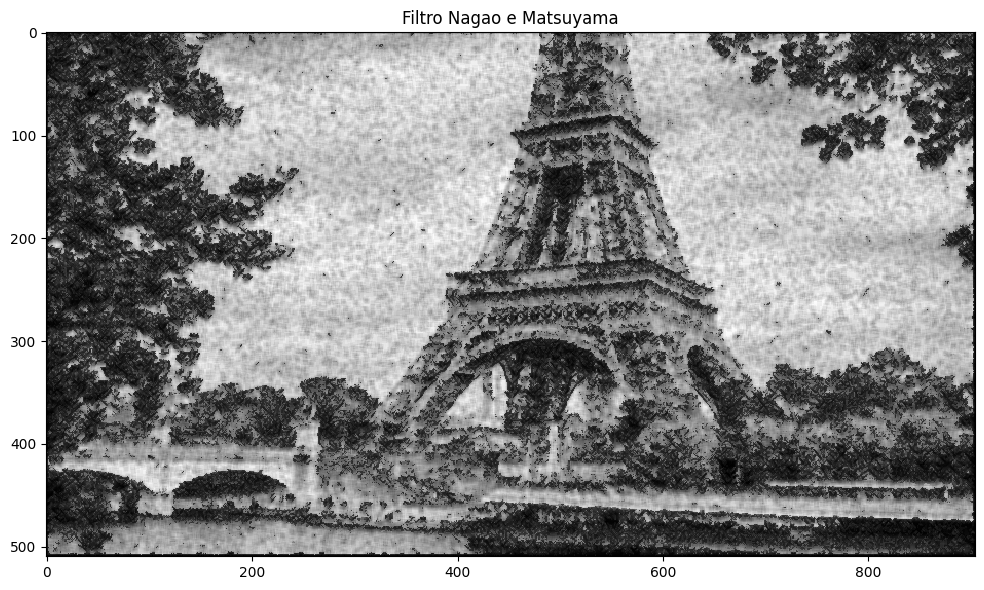

In [12]:
from scipy.signal import convolve2d
from skimage import io

def nagao_matsuyama_filter(img, janelaTamanho):
     # Adiciona bordas à imagem para processar as bordas corretamente
    img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_REFLECT)
    
    image = img.astype(np.float64)
    # Verificando se o tamanho da janela está correto

    if janelaTamanho % 4 != 1:
        raise Exception ("Tamanho de Janela Invalido")
    
    #Construindo Sub Janelas
    janela_1 = np.hstack((np.ones((1, (janelaTamanho-1)//2+1)), np.zeros((1, (janelaTamanho - 1)//2))))
    matriz_de_zeros = np.zeros((1, janelaTamanho))
    matriz_retangular = np.tile(janela_1, ((janelaTamanho - 1)//2+1,1))
    matriz_retangular = np.vstack((matriz_retangular, np.tile(matriz_de_zeros, ((janelaTamanho-1)//2, 1))))
    matriz_retangular = matriz_retangular/np.sum(matriz_retangular)
    # normaliza o kernel dividindo todos os seus elementos pela soma de 
    # todos os elementos,
    # o que garante que os pesos do kernel somam 1 (ou seja, a propriedade 
    # de filtro média)

    matriz_aux = matriz_retangular.copy()
    matriz_aux1 = matriz_retangular.copy()
    matriz_aux2 = matriz_retangular.copy()

    l = matriz_retangular[0][0] #0.4
    p = matriz_retangular[0][8] #0

    for i in range(len(matriz_aux)):
        for j in range(len(matriz_aux)):
            matriz_aux[i][j] = p
    
    for i in range(2, 7):
        for j in range(2, 7):
            matriz_aux[i][j] = l

    for i in range(len(matriz_aux1)):
        for j in range(len(matriz_aux1)):
            matriz_aux1[i][j] = p

    for i in range(0, 4):
        for j in range(2, 7):
            matriz_aux1[i][j] = l

    matriz_aux1[4][4] = l

    for i in range(len(matriz_aux2)):
        for j in range(len(matriz_aux2)):
            matriz_aux2[i][j] = p

    matriz_aux2[4][4] = l

    for i in range(0, 4):
        matriz_aux2[i][i] = l
        matriz_aux2[i+1][i] = l
        matriz_aux2[i][i+1] = l
    

    janelas = np.empty((9, janelaTamanho, janelaTamanho))
    janelas[0] = matriz_aux  # janelas[0] representa a direção do meio.
    janelas[1] = matriz_aux1 # janelas[1] representa a direção de cima.
    janelas[2] = np.fliplr(matriz_aux1) # janelas[2] representa a direção de baixo.
    janelas[3] = np.fliplr(matriz_aux1) # janelas[3] representa a direção de esquerda.
    janelas[4] = np.fliplr(janelas[3]) # janelas[4] representa a direção de direita.
    janelas[5] = matriz_aux2 # janelas[5] representa a diagonal esquerda superior.
    janelas[6] = np.fliplr(matriz_aux2) # janelas[5] representa a diagonal direita superior.
    janelas[7] = np.fliplr(matriz_aux2) # janelas[5] representa a diagonal esquerda inferior.
    janelas[8] = np.fliplr(janelas[7]) # janelas[5] representa a diagonal direita inferior.
   
    quadradoImg = image**2

    #alocando arrays
    avgs = np.zeros([9, image.shape[0], image.shape[1]])
    alocar = avgs.copy()

    #calculando a media de variancia
    for k in range(9):
        avgs[k] = convolve2d(image, janelas[k], mode='same')

        #media dos quadrados das subjanelas
        alocar[k] = convolve2d(quadradoImg, janelas[k], mode='same')

        #variancia das subjanelas
        alocar[k] = alocar[k] - avgs[k]**2

    #Escolhendo o indice com menor variancia
    indices = np.argmin(alocar, 0)

    #Construindo o filtro da imagem para cada pixel
    filtrado = np.zeros(img.shape)
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            filtrado[linha, coluna] = avgs[indices[linha, coluna], linha, coluna]

   
    return filtrado.astype(np.uint8)


imagem_ruido = np.array(Image.open('eifel_ruido.jpg'))

imgNagaoMatsuyama = nagao_matsuyama_filter(imagem_ruido, 9)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro Nagao e Matsuyama")
io.imshow(imgNagaoMatsuyama/255)
plt.show()



Em seguinte pode se observar como a imagem usando o filtro de Somboonkaew se comporta, ele é um filtro de suavização de bordas que utiliza uma combinação de 12 máscaras de suavização e uma máscara de realce para preservar as bordas em uma imagem.

Mesmo com o aumento das mascaras, imagem teve seu contraste aumentado, fora que alguns ruidos fora do objeto principal ainda se mantiveram, podendo se perceber que mesmo com alguns ruidos ainda foi reestabelecido o objeto central da imagem.

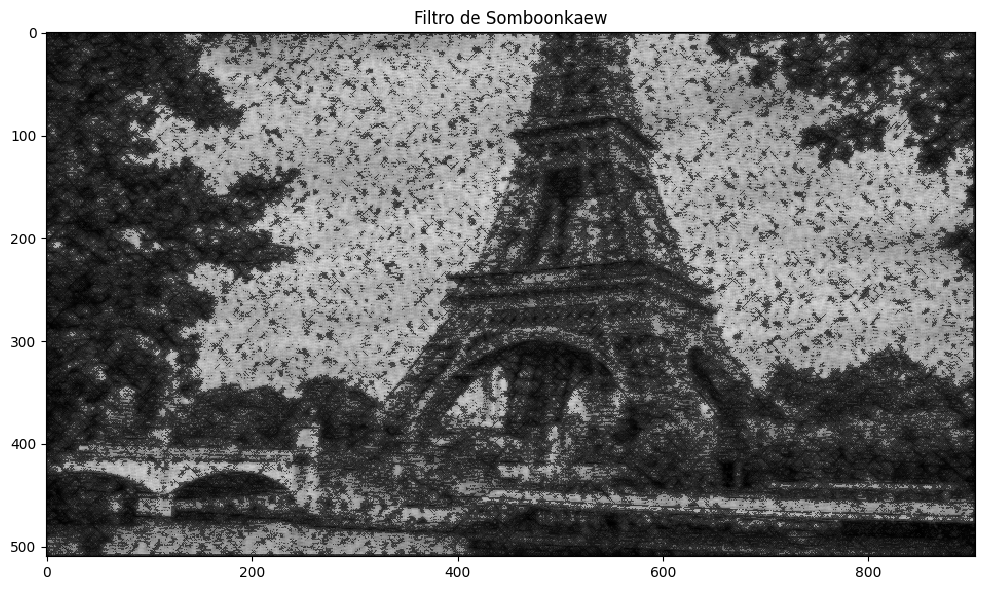

In [13]:
from scipy.signal import convolve2d
from skimage import io

def somboonkaew_filter(img, janelaTamanho):
     # Adiciona bordas à imagem para processar as bordas corretamente
    img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_REFLECT)
    
    image = img.astype(np.float64)
    # Verificando se o tamanho da janela está correto

    if janelaTamanho % 4 != 1:
        raise Exception ("Tamanho de Janela Invalido")
    
    #Construindo Sub Janelas
    janela_1 = np.hstack((np.ones((1, (janelaTamanho-1)//2+1)), np.zeros((1, (janelaTamanho - 1)//2))))
    matriz_de_zeros = np.zeros((1, janelaTamanho))
    matriz_retangular = np.tile(janela_1, ((janelaTamanho - 1)//2+1,1))
    matriz_retangular = np.vstack((matriz_retangular, np.tile(matriz_de_zeros, ((janelaTamanho-1)//2, 1))))
    matriz_retangular = matriz_retangular/np.sum(matriz_retangular)
    # normaliza o kernel dividindo todos os seus elementos pela soma de 
    # todos os elementos,
    # o que garante que os pesos do kernel somam 1 (ou seja, a propriedade 
    # de filtro média)

    matriz_aux = matriz_retangular.copy()

    l = matriz_retangular[0][0] #0.4
    p = matriz_retangular[0][8] #0

    for i in range(len(matriz_aux)):
        for j in range(len(matriz_aux)):
            matriz_aux[i][j] = p

    matriz_aux1 = matriz_aux.copy()
    matriz_aux2 = matriz_aux.copy()
    matriz_aux3 = matriz_aux.copy()
    matriz_aux4 = matriz_aux.copy()

    for i in range(len(matriz_aux)):
        matriz_aux[i][i] = l
        
    matriz_aux[3][5] = l
    matriz_aux[5][3] = l

    for i in range(len(matriz_aux1)):
        matriz_aux1[4][i] = l
        if(i == 4):
            matriz_aux1[i+1][i] = l
            matriz_aux1[i-1][i] = l

    for i in range(2, len(matriz_aux2) - 2):
        for j in range(2, len(matriz_aux2) - 2):
            matriz_aux2[i][j] = l
            if(i == 4):
                matriz_aux2[i][j] = p

    matriz_aux2[4][4] = l

    for i in range(2, 6):
        matriz_aux3[i][i] = l
        matriz_aux3[i+1][i] = l
        matriz_aux3[i][i+1] = l
    matriz_aux3[6][6] = l

    for i in range(2, 5):
        for j in range(2, 7):
            matriz_aux4[i][j] = l
    matriz_aux4[5][4] = l
    matriz_aux4[6][4] = l

    janelas = np.empty((12, janelaTamanho, janelaTamanho))
    janelas[0] = matriz_aux
    janelas[1] = np.fliplr(matriz_aux)
    janelas[2] = matriz_aux1
    janelas[3] = np.fliplr(matriz_aux1)
    janelas[4] = matriz_aux2
    janelas[5] = np.fliplr(matriz_aux2)
    janelas[6] = matriz_aux3
    janelas[7] = np.fliplr(matriz_aux3)
    janelas[8] = matriz_aux4
    janelas[9] = np.fliplr(matriz_aux4)
    janelas[10] = np.fliplr(matriz_aux4)
    janelas[11] =np.fliplr(janelas[10])
   
    quadradoImg = image**2

    #alocando arrays
    avgs = np.zeros([12, image.shape[0], image.shape[1]])
    alocar = avgs.copy()

    #calculando a media de variancia
    for k in range(12):
        avgs[k] = convolve2d(image, janelas[k], mode='same')

        #media dos quadrados das subjanelas
        alocar[k] = convolve2d(quadradoImg, janelas[k], mode='same')

        #variancia das subjanelas
        alocar[k] = alocar[k] - avgs[k]**2

    #Escolhendo o indice com menor variancia
    indices = np.argmin(alocar, 0)

    #Construindo o filtro da imagem para cada pixel
    filtrado = np.zeros(img.shape)
    for linha in range(img.shape[0]):
        for coluna in range(img.shape[1]):
            filtrado[linha, coluna] = avgs[indices[linha, coluna], linha, coluna]

   
    return filtrado.astype(np.uint8)


imagem_ruido = cv2.imread('eifel_ruido.jpg', 0)

imgSomboonkaew = somboonkaew_filter(imagem_ruido, 9)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro de Somboonkaew")
io.imshow(imgSomboonkaew/255)
plt.show()

Por fim podemos analisar o filtro de Adelmann, é um filtro de borda que pode ser usado para realçar as bordas em uma imagem. Ele usa uma máscara de convolução para calcular a diferença entre os valores de pixel em duas direções diferentes.

Inicialmente, um teste é realizado para cada pixel da
imagem para determinar se ele está localizado sobre uma
borda, considerando-se cada uma das possíveis orientações
representadas pelas 4 máscaras de 5×5 pixels a seguir. 

A função recebe como entrada uma imagem representada por um array numpy e um limiar que define o nível de diferença máxima permitido entre as quatro máscaras utilizadas pelo filtro.

A função cria uma cópia da imagem de entrada com uma borda replicada ao seu redor e, em seguida, itera sobre a imagem para calcular a diferença entre as quatro máscaras (duas horizontais e duas verticais) e encontrar a maior diferença. Se a diferença for maior que o limiar definido, o pixel em questão é substituído pela média dos pixels vizinhos, caso contrário, o pixel é substituído pela média dos pixels vizinhos e ele mesmo.

A imagem retornada apresenta preservações de bordas, contudo deixando alguns vestigios do ruido aplicado anteriormente. Pode se notar alguma interferencia que ocorre na metade da imagem por conta dos ruidos aplicados. Provavel que dessa parte para a direita da imagem ela encontre mais bordas e não consiga preservar tanto assim ela.


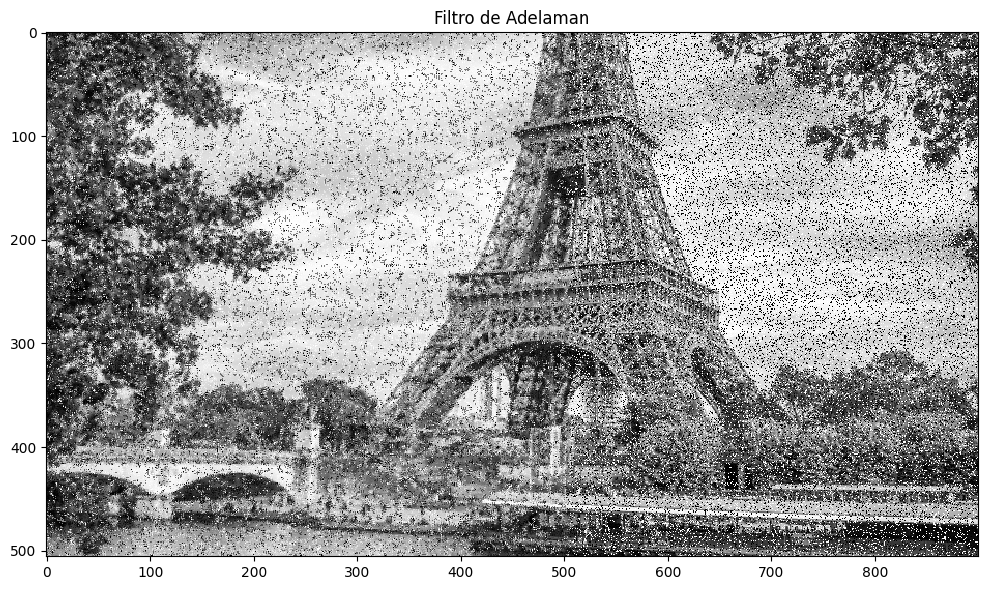

In [16]:
import numpy as np
from skimage import io

def adelmann_filter(img: np.ndarray, limiar: int) -> np.ndarray:

    img = cv2.copyMakeBorder(img, 2, 2, 2, 2, cv2.BORDER_REPLICATE)
    imgFinal = img.copy()

    for m in range(2, img.shape[0]-2):
        for n in range(2, img.shape[0]-2):
            # Logo abaixo é definido a criação das quatro mascaras
            # Sendo um veritical e horizontal e duas verticais
            a1 = img[m-1, n-2:n+3]
            a2 = img[m+1, n-2:n+3]
            a = abs(np.mean(a1) - np.mean(a2))

            b1 = img[m-2:m+3, n-1]
            b2 = img[m-2:m+3, n+1]
            b = abs(np.mean(b1) - np.mean(b2))

            c1 = [img[m-1, n-2], img[m, n-1], img[m+1, n], img[m+2, n+1]]
            c2 = [img[m-2, n-1], img[m-1, n], img[m, n+1], img[m+1, n+2]]
            c = abs(np.mean(c1) - np.mean(c2))

            d1 = [img[m-2, n+1], img[m-1, n], img[m, n-1], img[m+1, n-2]]
            d2 = [img[m-1, n+2], img[m, n+1], img[m+1, n], img[m+2, n-1]]
            d = abs(np.mean(d1) - np.mean(d2))

            diferencas = [a, b, c, d] #
            indiceDaDiferencaMaxima = np.argmax(diferencas)

            if diferencas[indiceDaDiferencaMaxima] > limiar:
                if indiceDaDiferencaMaxima == 0:
                    imgFinal[m, n] = np.mean([img[m, n-1], img[m, n+1]])
                elif indiceDaDiferencaMaxima == 1:
                    imgFinal[m, n] = np.mean([img[m-1, n], img[m+1, n]])
                elif indiceDaDiferencaMaxima == 2:
                    imgFinal[m, n] = np.mean([img[m-1, n-1], img[m+1, n+1]])
                elif indiceDaDiferencaMaxima == 3:
                    imgFinal[m, n] = np.mean([img[m-1, n+1], img[m+1, n-1]])
            else:
                imgFinal[m, n] = np.mean([img[m, n-1], img[m, n+1], img[m-1, n], img[m+1, n]])
            
    imgFinal = imgFinal[2:imgFinal.shape[0]-2, 2:imgFinal.shape[1]-2]

    return imgFinal

imagem_ruido = cv2.imread('eifel_ruido.jpg', 0)

imgAdelman = adelmann_filter(imagem_ruido, 5)

plt.figure(figsize=(15, 6)) 
plt.title("Filtro de Adelaman")
io.imshow(imgAdelman/255)
plt.show()

Questão 02: Faça um estudo de caso utilizando imagens coloridas.

• Verifique a interferência do ruído em um ou mais canais de cor na detecção das bordas;
• Utilize ao menos um exemplo de imagem com bordas entre regiões de cores diferentes
mas com mesma intensidade.

Pode ser identificado no estudo abaixo a interferência do ruído em um canal de cor específico na detecção de bordas em uma imagem colorida, assim como a diferença na nitidez das bordas entre regiões de cores diferentes, mas com mesma intensidade.

Mesmo com a adição do ruido não parecer ser muito aparente na imagem, quando tentamos detectar as bordas novamente é possivel visualizar a falha por conta do ruido, produzindo uma tentativa mal elaborada ao enocntrar as bordas.

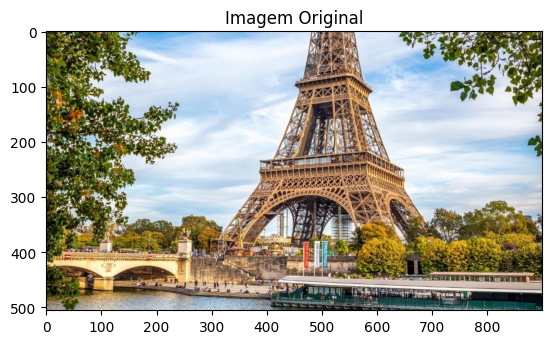

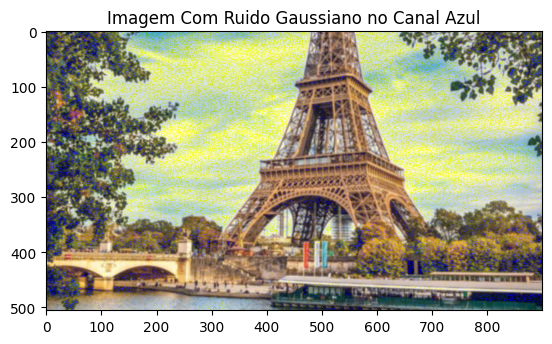

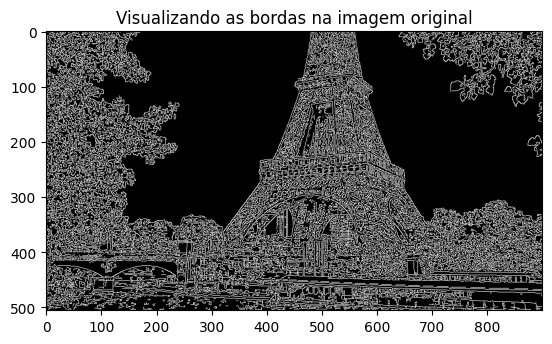

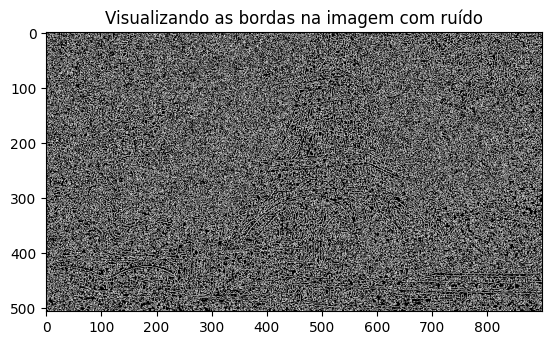

In [15]:
# Carregando a imagem
eifel = cv2.imread('eifel.jpg')

# Convertendo para RGB
eifel = cv2.cvtColor(eifel, cv2.COLOR_BGR2RGB)

# Visualizando a imagem
plt.imshow(eifel)
plt.title("Imagem Original")
plt.show()

# Adicionando ruído gaussiano no canal azul
blur = cv2.GaussianBlur(eifel, (5,5), 0)
ruido = np.zeros_like(eifel)
ruido[:,:,2] = np.random.normal(0, 25, (eifel.shape[0], eifel.shape[1]))
noisy_img = blur + ruido

# Visualizando a imagem com ruído
plt.imshow(noisy_img)
plt.title("Imagem Com Ruido Gaussiano no Canal Azul")
plt.show()

# Detectando as bordas na imagem original
bordas = cv2.Canny(eifel, 100, 200)

# Visualizando as bordas na imagem original
plt.imshow(bordas, cmap='gray')
plt.title("Visualizando as bordas na imagem original")
plt.show()

# Detectando as bordas na imagem com ruído
noisy_edges = cv2.Canny(noisy_img, 100, 200)

# Visualizando as bordas na imagem com ruído
plt.imshow(noisy_edges, cmap='gray')
plt.title("Visualizando as bordas na imagem com ruído")
plt.show()